# Implementation of the transformer architecture

#  Packages

In [1]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization, Conv1D, Reshape

print(tf.__version__)

2.17.1


# Sub layers

**Attention m - Single head attention**

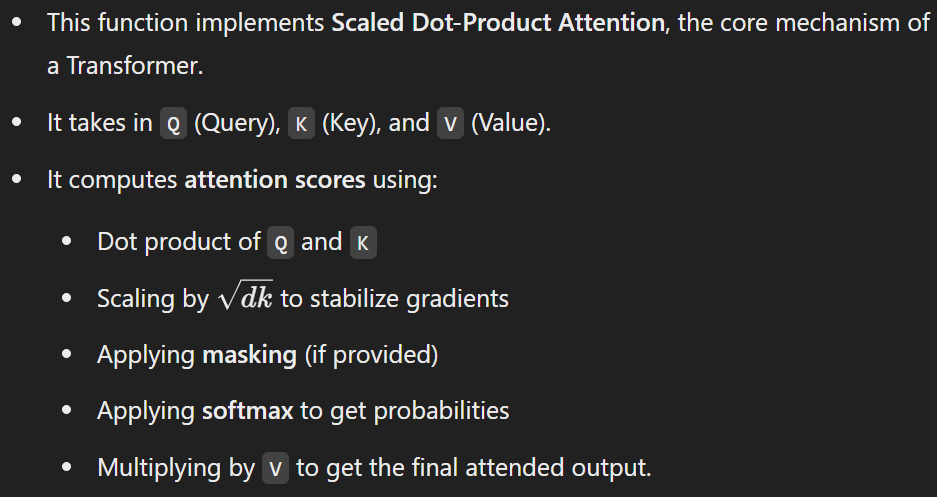
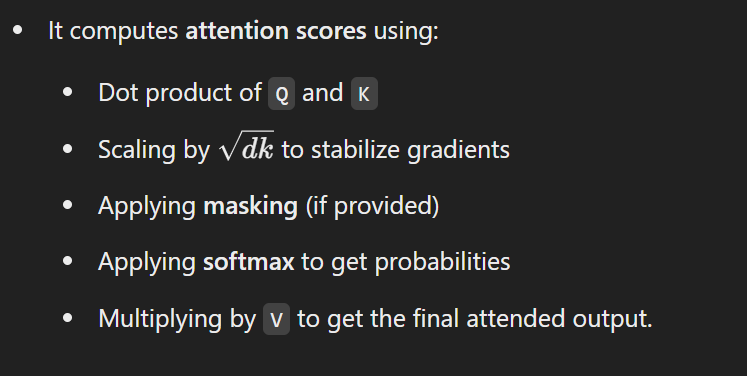

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Calculate the attention weights.

    Arguments:
        Q -- query shape == (..., Tq, dk)
        K -- key shape == (..., Tv, dk)
        V -- value shape == (..., Tv, dv)
        mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.

    Returns:
        output -- (attention,attention_weights)
    """
    
    #Compute the scaled dot-product Q•K
    matmul_QK = tf.matmul(Q,K,transpose_b=True)  # dot-product of shape (..., Tq, Tv)

    dk = K.shape[-1]
    scaled_attention_logits = matmul_QK/np.sqrt(dk) # scaled dot-product of shape (..., Tq, Tv)

    # Add the mask to the scaled dot-product
    
    if mask is not None: 
        scaled_attention_logits += (1. - mask) *(-1e9)

    # Compute the Softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # weights of shape (..., Tq, Tv)

    #Multiply with V
    output = tf.matmul(attention_weights,V)  # Attention representation of shape (..., Tq, dv)
    
    return output, attention_weights

# **Explanation:**

* This creates random tensors Q, K, V with batch size 16.
* It calls scaled_dot_product_attention() and prints the output shape.


In [3]:
batch_size, Tq, Tv, dk, dv = 16, 9,9, 64, 128
Q = tf.random.uniform((batch_size, Tq, dk))
K = tf.random.uniform((batch_size, Tv, dk))
V = tf.random.uniform((batch_size, Tv, dv))

A,_= scaled_dot_product_attention(Q, K, V)
print(A.shape)

(16, 9, 128)


### MultiHead Attention 

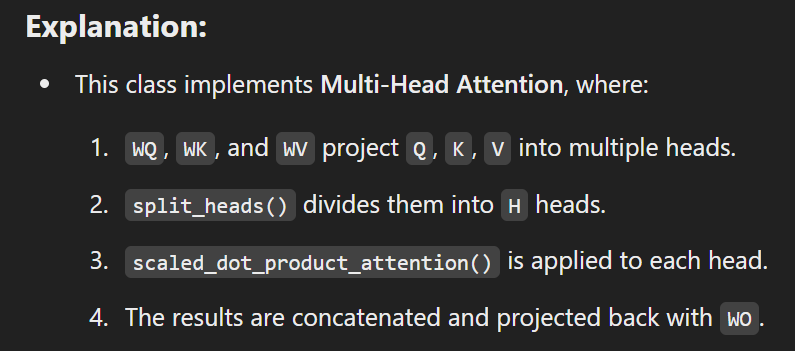

In [4]:
class Multihead_Attention(tf.keras.layers.Layer):
    def __init__(self, H, d_model, dk, dv):
        
        """
        Arguments:
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        """
    
        super(Multihead_Attention, self).__init__()
        
        initializer = tf.keras.initializers.GlorotUniform()
        self.WQ = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WK = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WV = tf.Variable(initializer(shape=(H, d_model, dv)), trainable=True)
        self.WO = tf.Variable(initializer(shape=(H*dv,d_model)), trainable=True)

    
    def call(self, Q, K, V, mask=None):
        """
        Calculate the attention weights.

        Arguments:
            Q -- query shape == (..., Tq, d_model)
            K -- key shape == (..., Tv, d_model)
            V -- value shape == (..., Tv, d_model)
            mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.

        Returns:
            output -- Multihead attention A of shape (batch_size, Tq, d_model)
        """
        #Projecting Q,K,V to Qh, Kh, Vh. The H projection are stacked on the penultiem axis
        Qh= tf.experimental.numpy.dot(Q, self.WQ) #of shape (batch_size, Tq, H, dk)
        Kh= tf.experimental.numpy.dot(K, self.WK) #of shape (batch_size, Tv, H, dk)
        Vh= tf.experimental.numpy.dot(V, self.WV) #of shape (batch_size, Tv, H, dv)
        
        #Transposition
        Qh=tf.transpose(Qh, [0,2,1,3]) #of shape (batch_size, H, Tq, dk)
        Kh=tf.transpose(Kh, [0,2,1,3]) #of shape (batch_size, H, Tv, dk)
        Vh=tf.transpose(Vh, [0,2,1,3]) #of shape (batch_size, H, Tv, dv)
        
        # Computing the dot-product attention
        Ah,_=scaled_dot_product_attention(Qh, Kh, Vh, mask=mask) #of shape (batch_size, H, Tq, dv)
        
        #Flattening the H and dv axis and projecting back to d_model
#        A = tf.reshape(Ah,(*Ah.shape[:-2],-1))
        s=Ah.shape
        A = tf.reshape(Ah,(s[0],s[2],s[1]*s[3])) #of shape (batch_size, Tq, H*dv)
        A= tf.experimental.numpy.dot(A, self.WO) #of shape (batch_size, Tq, d_model)
        
        return A

# **Explanation:**
* It initializes a Multihead_Attention layer with H=8 heads.
* It passes in random Q, K, and V with d_model=512.
* It prints the shape of the attention output.



In [5]:
##Debug

H, d_model, dk, dv = 8, 512, 64, 32
batch_size, tq, Tv = 16, 9, 9

mha_layer = Multihead_Attention(H, d_model, dk, dv)

Q = tf.random.uniform((batch_size, tq,d_model))
K = tf.random.uniform((batch_size,Tv, d_model))
V = tf.random.uniform((batch_size, Tv, d_model))

A = mha_layer(Q, K, V)
print(A.shape)

(16, 9, 512)


# Pointwise FNN 
A Pointwise Feed-Forward Network is a fully connected (dense) layer that processes each token (word) independently, without considering neighboring words.
* Pointwise" means it operates on each position separately (without interaction between different words).
* "Feed-Forward Network" means it consists of dense layers (like in standard deep learning models).

In [6]:
class PointWise_FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):

        """ 
        d_model -- the dimension of the embedding (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        """
        super(PointWise_FeedForward, self).__init__()
        self.fc1 = tf.keras.layers.Dense(dff, activation = 'relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        """
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            
        Returns:
            fnn_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [7]:
d_model, dff = 64, 2048
fnn_layer = PointWise_FeedForward(d_model, dff)

batch_size, Tv = 16, 9
x = tf.random.uniform((batch_size, Tv, d_model))

print(fnn_layer(x).shape)


(16, 9, 64)


## Positional encoding

In [8]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size d_model
    
        arguments de get_angles:
            pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
            k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
            d(integer) -- Encoding size
            
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    #Initialize a matrix angle_rads of all the angles
    pos = np.arange(positions)[:, np.newaxis] #column vector containing the position span[0, 1..., positions]
    k = np,arange(d)[np.newaxis, :] #row vector containing the dimension span[[0, 1, ..., d-1]]
    i = k//2
    
    angle_rads = pos/(10000**(2*i/d)) #Matrix of angles indexed by (pos,i)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    #adds batch axis
    pos_encoding = angle_rads[np.newaxis, ...] 
    
    return tf.cast(pos_encoding, dtype=tf.float32)